<a href="https://colab.research.google.com/github/pedromazim/visao/blob/main/project_fractal_dimension_texture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import skimage as skm
import matplotlib.pyplot as pt
import matplotlib.colors as cm
#import porespy as ps
from numba import jit

In [22]:
def make_gray(img, weights):

    '''
    converts an colored RGB image to grayscale

    img : image to be converted
    weights : list or array containing the relative weights of red, blue and green for conversion

    '''

    if len(img.shape) == 3:

        img_recol = np.zeros((img.shape[0],img.shape[1]))

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                    img_recol[i,j] = weights[0]*img[i,j,0] + weights[1]*img[i,j,1] + weights[2]*img[i,j,2]

        return img_recol
    else:
        return img

def histogram(img):

    '''
    returns the histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = np.zeros_like(bins)

    for b in bins:
        counts[b] = np.where(img==b)[0].size

    return counts

def cdf_histogram(img):

    '''
    returns the cummulative histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = histogram(img)
    cdf_counts = np.zeros_like(counts)

    for b in bins:
        cdf_counts[b] = np.sum(counts[0:b])/(img.size)

    return cdf_counts

def otsu_thresholding(img):
    img = img.flatten()
    hist = histogram(img)
    cdf = cdf_histogram(hist)
    mean_gray = np.mean(img)
    var = np.zeros_like(hist)

    for t in range(256):
        # computing class probability (background and foreground)
        pb = img[img<t].size
        wb = pb/img.size
        wf = 1-wb

        if wb != 0 and wb != 1:
            mb = np.sum(img[img<t])/pb
            mf = np.sum(img[img>=t])/(img.size-pb)

            vb = np.sum((img[img<t]-mb)**2)/pb
            vf = np.sum((img[img>=t]-mf)**2)/(img.size-pb)

        elif wb == 1:
            continue
        else:
            continue

        var[t] = wb*vb + wf*vf
    count = 0
    for v in var:
        if v != 0:
            break
        else:
            count+=1
        #print(wb,vb, wf,vf, var[t])
    threshold = np.argmin(var[np.nonzero(var)]) + count

    return threshold

In [23]:
img = skm.io.imread('https://github.com/pedromazim/visao/blob/main/images/frac1-1.png?raw=true')[:,:,:3]

In [24]:
img = make_gray(img,[1/3,1/3,1/3])

In [9]:
thd = otsu_thresholding(img)

ValueError: attempt to get argmin of an empty sequence

In [ ]:
test = img < thd

In [25]:
img = img < 100

(-0.5, 431.5, 431.5, -0.5)

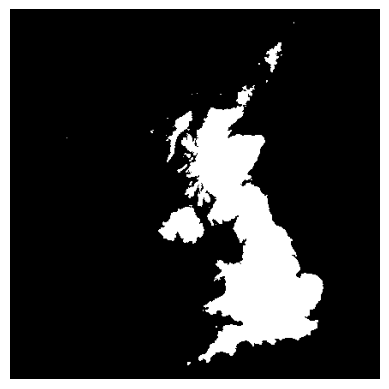

In [26]:
pt.imshow(img, cmap='gray')
pt.axis('off')

### Box-counting method

In [65]:
def bcm(img, res):
    grid = np.zeros_like(img)
    h, w = img.shape
    sizes = []
    counts = []

    for i in range(res):# divide squares each loop
        L = 2**(i)
        sizes.append(h/L)
        counter = 0
        for m in range(L):# loop for height
            for n in range(L):#loop for width
                if img[int(m*h/L):int((m+1)*h/L),int(n*w/L):int((n+1)*w/L)].any() == 1:
                    counter += 1
        counts.append(counter)
    return sizes, counts

In [66]:
# guardamos o numero de caixas que contem uma parte da imagem
# em função do tamanho da caixa
squares = bcm(img, 10)
coeffs = np.polyfit(np.log(squares[0]),np.log(squares[1]),1)

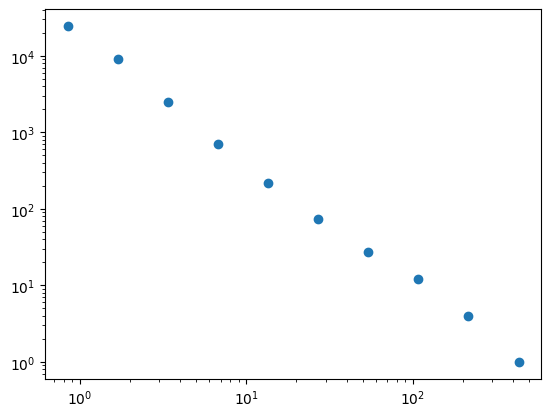

In [26]:
pt.scatter(squares[0], squares[1])
#pt.plot(np.log(squares[0]), np.poly1d(coeffs)(squares[0]))
pt.xscale('log')
pt.yscale('log')

### Bouligand-Minkowsky method
Input is a binary image\
Step 1: Obtain the edge pixels by euclidean distance transform (EDT)\
Step 2: Set a disk of radius r and count every pixel under its influence area;\
Step 3: Repeat for every edge pixel;\
Step 4: Repeat for many r values;\
Step 5: Obtain FD by linearization of A(r) x r.

In [52]:
@jit(nopython=True, looplift=True)
def edt(img):# euclidean distance from foreground to background pixels
    img = img.astype('int')
    h, w = img.shape
    d = np.zeros((h,w))
    for y in range(h):
        for x in range(w):
            if img[x,y] == 1:
                flag = True
                r = 1
                while flag:
                    nb = img[x-r:x+r+1,y-r:y+r+1]
                    if np.flatnonzero(nb).size != nb.size:
                        d[x,y] = r
                        flag = False
                    else:
                        r += 1
    return d

@jit(nopython=True, looplift=True)
def distance(img, x0, y0):# distance from all pixels to a specific one
    img = img.astype('int')
    h, w = img.shape
    dist = np.zeros_like(img)
    for y in range(h):
        for x in range(w):
            dist[x,y] = np.sqrt((x-x0)**2+(y-y0)**2)
    return dist

@jit(nopython=False, looplift=True)
def bmm(img, R):

    img = img.astype('int')

    dt = edt(img)
    edge = np.argwhere(dt==1)
    counts = []
    for r in range(1,R+1):# calculates influence area for multiple r values
        print(r)
        c = 0
        for px in edge:
            A_r = np.flatnonzero(np.where(distance(img, px[0],px[1]) <= r))
            c += A_r.size
        counts.append(c)

    return np.arange(R+1), counts

<ipython-input-52-f3177cc6e766>:30: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False, looplift=True)


(-0.5, 431.5, 431.5, -0.5)

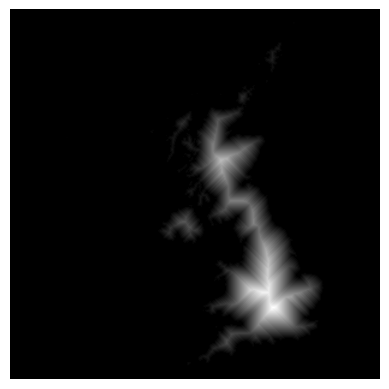

In [30]:
dt = edt(img)
pt.imshow(dt, cmap='gray', vmin=0, vmax=dt.max())
pt.axis('off')

In [53]:
min_df = bmm(img,10)

<ipython-input-52-f3177cc6e766>:30: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bmm" failed type inference due to: No implementation of function Function(<function flatnonzero at 0x7a40acb7cd30>) found for signature:
 
 >>> flatnonzero(UniTuple(array(int64, 1d, C) x 2))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_flatnonzero': File: numba/np/arraymath.py: Line 2956.
        With argument(s): '(UniTuple(array(int64, 1d, C) x 2))':
       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       No implementation of function Function(<built-in function asarray>) found for signature:
        
        >>> asarray(UniTuple(array(int64, 1d, C) x 2))
        
       There are 2 candidate implementations:
             - Of which 2 did not match due to:
             Overload in function

0
1
2
3
4
5
6
7
8
9
10


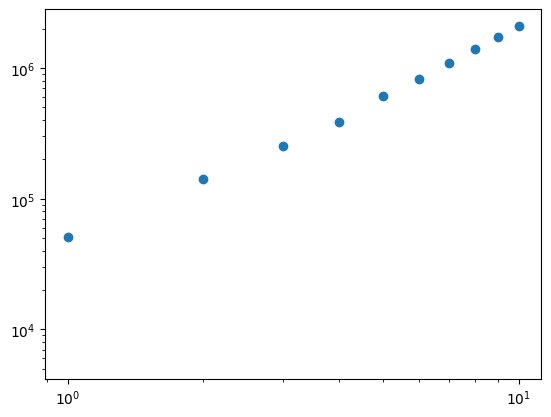

In [55]:
pt.scatter(min_df[0], min_df[1])
pt.yscale('log')
pt.xscale('log')

In [60]:
minkowski = np.log(min_df)

<ipython-input-60-2a416fe803ce>:1: RuntimeWarning: divide by zero encountered in log
  minkowski = np.log(min_df)


In [63]:
coeffs = np.polyfit(np.log(min_df[0][1:]),np.log(min_df[1][1:]),1)

In [1]:
from PIL import Image
for image in

SyntaxError: invalid syntax (<ipython-input-1-fc9496f97e8e>, line 1)